## F0 estimation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import find_peaks

def autocorrelation(x):
    """Compute autocorrelation of signal x."""
    x = x - np.mean(x)  # Remove DC component
    corr = np.correlate(x, x, mode='full')
    return corr[len(corr)//2:]  # Return non-negative lags

def estimate_f0(signal, fs, frame_size=1024, hop_size=512):
    """Estimate f0 using autocorrelation method and track the frequency."""
    num_frames = (len(signal) - frame_size) // hop_size
    f0_values = []

    for i in range(num_frames):
        start_idx = i * hop_size
        end_idx = start_idx + frame_size
        frame = signal[start_idx:end_idx]
        
        # Calculate autocorrelation
        corr = autocorrelation(frame)
        
        # Find the first peak (excluding lag 0)
        peaks, _ = find_peaks(corr[1:])  # Find peaks starting from index 1 (ignore lag=0)
        
        if len(peaks) > 0:
            # The lag corresponding to the fundamental frequency
            fundamental_period = peaks[0] + 1  # Add 1 to account for the 1-indexing in find_peaks
            f0 = fs / fundamental_period
        else:
            f0 = 0  # If no peak found, assume silence or unidentifiable pitch
        
        f0_values.append(f0)
    
    return f0_values

def plot_f0(f0_values, fs, hop_size):
    """Plot the estimated f0 over time."""
    time = np.arange(0, len(f0_values) * hop_size, hop_size) / fs
    plt.plot(time, f0_values, label="Estimated f0")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Fundamental Frequency Estimation")
    plt.show()

# Load WAV file
filename = 'audio_files/sitar_notes.wav'  # Replace with your file path
fs, x = wav.read(filename)


(0.0, 18.004172335600906)

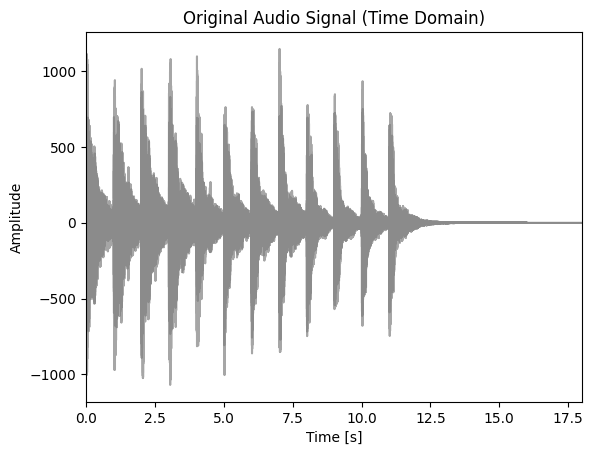

In [5]:

signal_time = np.arange(0, len(x)) / fs

# Plot the original signal
plt.plot(signal_time, x, label="Original Signal", color='gray', alpha=0.7)
plt.title("Original Audio Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, len(x) / fs)


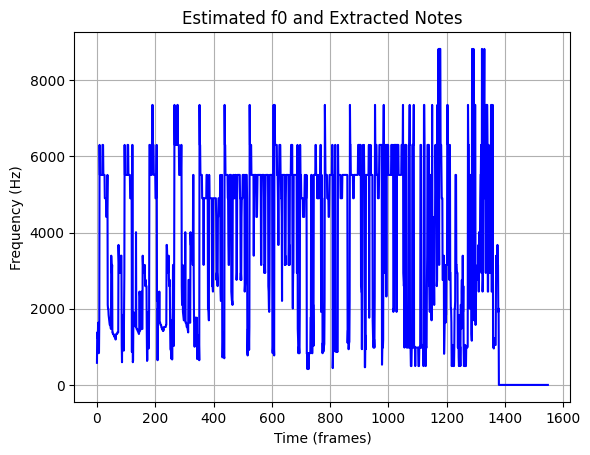

In [64]:
import numpy as np
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def f0_to_midi(f0):
    """Convert fundamental frequency (f0) to MIDI note number."""
    if f0 > 0:  # Ignore zero or non-pitched frequencies
        midi_note = 69 + 12 * np.log2(f0 / 440.0)
        return int(round(midi_note))  # Round to nearest integer
    else:
        return None  # No valid note for f0 <= 0

def f0_to_note_name(midi_note):
    """Convert MIDI note number to note name."""
    # List of note names in one octave
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1  # MIDI notes start from C-1, so subtract 1 for octave
    note = note_names[midi_note % 12]
    return f"{note}{octave}"

def extract_notes_from_f0(f0_values):
    """Extract musical notes from the fundamental frequency (f0) values."""
    notes = []
    midi_notes = []
    for f0 in f0_values:
        midi_note = f0_to_midi(f0)
        if midi_note is not None:
            note_name = f0_to_note_name(midi_note)
            notes.append(note_name)
            midi_notes.append(midi_note)
        else:
            notes.append(None)  # No valid note for f0 <= 0
    return notes, midi_notes



hop_size=512
num_frames = len(f0_values)
f0_time = np.arange(0, num_frames) * hop_size / fs

# Assuming f0_values are already obtained from previous estimation
f0_values = estimate_f0(x, fs)

# Extract notes from the fundamental frequency (f0)
notes, midi_notes = extract_notes_from_f0(f0_values)


# Optionally, plot the extracted notes
plt.plot(f0_values, label="Estimated f0 (Hz)", color='blue')
plt.title("Estimated f0 and Extracted Notes")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()


In [66]:
import numpy as np
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mido import Message, MidiFile, MidiTrack

def f0_to_midi(f0):
    """Convert fundamental frequency (f0) to MIDI note number."""
    if f0 > 0:  # Ignore zero or non-pitched frequencies
        midi_note = 69 + 12 * np.log2(f0 / 440.0)
        return int(round(midi_note))  # Round to nearest integer
    else:
        return None  # No valid note for f0 <= 0

def f0_to_note_name(midi_note):
    """Convert MIDI note number to note name."""
    # List of note names in one octave
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1  # MIDI notes start from C-1, so subtract 1 for octave
    note = note_names[midi_note % 12]
    return f"{note}{octave}"

def extract_notes_from_f0(f0_values, fs, hop_size):
    """Extract musical notes and their durations from the fundamental frequency (f0) values."""
    notes = []
    durations = []
    
    prev_note = None
    start_time = 0  # Track when a note starts
    for i, f0 in enumerate(f0_values):
        midi_note = f0_to_midi(f0)
        current_time = i * hop_size / fs  # Current time in seconds
        
        if midi_note is not None:
            # If the note has changed or it's a new note
            if midi_note != prev_note:
                if prev_note is not None:
                    # Store the previous note and its duration
                    note_duration = current_time - start_time
                    notes.append((prev_note, start_time, note_duration))
                # Update with new note
                prev_note = midi_note
                start_time = current_time
        
        else:
            # Handle case where there's no valid note (f0 <= 0)
            if prev_note is not None:
                note_duration = current_time - start_time
                notes.append((prev_note, start_time, note_duration))
                prev_note = None
    
    # For the last note
    if prev_note is not None:
        note_duration = current_time - start_time
        notes.append((prev_note, start_time, note_duration))
    
    return notes

def create_midi(notes, midi_filename):
    """Create a MIDI file from the extracted notes and their durations."""
    midi = MidiFile()
    track = MidiTrack()
    midi.tracks.append(track)

    # Set the tempo (500000 microseconds per beat, ~120 bpm)
    track.append(Message('program_change', program=12))  # Acoustic Grand Piano
    for note, start_time, duration in notes:
        start_ticks = int(start_time * 480)  # Convert time to ticks (480 ticks per beat)
        duration_ticks = int(duration * 480)
        
        # Add note-on and note-off messages
        track.append(Message('note_on', note=note, velocity=64, time=start_ticks))
        track.append(Message('note_off', note=note, velocity=64, time=duration_ticks))
    
    # Save the MIDI file
    midi.save(midi_filename)

# Load the sitar WAV file
filename = 'audio_files/sitar_noisy3.wav'  # Replace with your file path
fs, signal = wav.read(filename)

# Convert stereo to mono if needed
if len(signal.shape) > 1:
    signal = np.mean(signal, axis=1)

# Estimate f0 and track it
f0_values = estimate_f0(signal, fs)

# Extract notes and their durations
notes = extract_notes_from_f0(f0_values, fs, hop_size=512)

# Print the extracted notes and durations
for note, start_time, duration in notes:
    note_name = f0_to_note_name(note)
    print(f"Note: {note_name}, Start time: {start_time:.2f}s, Duration: {duration:.2f}s")

# Create the MIDI file from the extracted notes
create_midi(notes, "output_sitar_notes.mid")


Note: E8, Start time: 0.00s, Duration: 0.01s
Note: C7, Start time: 0.01s, Duration: 0.02s
Note: A7, Start time: 0.03s, Duration: 0.01s
Note: C#7, Start time: 0.04s, Duration: 0.02s
Note: G#6, Start time: 0.06s, Duration: 0.01s
Note: C#7, Start time: 0.07s, Duration: 0.01s
Note: D7, Start time: 0.09s, Duration: 0.01s
Note: D#6, Start time: 0.10s, Duration: 0.03s
Note: F6, Start time: 0.13s, Duration: 0.01s
Note: G6, Start time: 0.14s, Duration: 0.02s
Note: F#6, Start time: 0.16s, Duration: 0.01s
Note: D#6, Start time: 0.17s, Duration: 0.04s
Note: G6, Start time: 0.21s, Duration: 0.02s
Note: D#6, Start time: 0.23s, Duration: 0.03s
Note: F#6, Start time: 0.27s, Duration: 0.01s
Note: G6, Start time: 0.28s, Duration: 0.01s
Note: F#8, Start time: 0.29s, Duration: 0.01s
Note: A5, Start time: 0.30s, Duration: 0.01s
Note: G6, Start time: 0.31s, Duration: 0.01s
Note: D7, Start time: 0.32s, Duration: 0.01s
Note: C#7, Start time: 0.33s, Duration: 0.01s
Note: C#6, Start time: 0.34s, Duration: 0.01s

/tmp/ipykernel_50420/786832240.py:80: WavFileWarning: Reached EOF prematurely; finished at 1920079 bytes, expected 4294967303 bytes from header.
  fs, signal = wav.read(filename)
